# Variational Auto Encoder
![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1712.png)

In [25]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

torch.manual_seed(660)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

kwargs = {'num_workers': 1, 
          'pin_memory': True} if device == 'cuda' else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='/home/i008/data/', 
                   train=True, 
                   download=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, 
    shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/home/i008/data/', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class ConvolutionalVAEAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flat = nn.Flatten()
        self.mu = nn.Linear(576, 30)
        self.logvar = nn.Linear(576, 30)
        self.unflat = nn.Linear(30, 576)
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),    
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        

    def decode(self, sample):
        
        x = self.unflat(sample).view(-1, 64, 3, 3)
        return F.sigmoid(self.decoder(x))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps*std
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.flat(x)    
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        sample = self.reparameterize(mu, logvar)
        
        
        return self.decode(sample), mu, logvar
        


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


model = ConvolutionalVAEAutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 30).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 586.928467
Train Epoch: 1 [1280/60000 (2%)]	Loss: 271.458649
Train Epoch: 1 [2560/60000 (4%)]	Loss: 235.987213
Train Epoch: 1 [3840/60000 (6%)]	Loss: 219.463638
Train Epoch: 1 [5120/60000 (9%)]	Loss: 209.971176
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.977020
Train Epoch: 1 [7680/60000 (13%)]	Loss: 222.263870
Train Epoch: 1 [8960/60000 (15%)]	Loss: 218.207901
Train Epoch: 1 [10240/60000 (17%)]	Loss: 211.524139
Train Epoch: 1 [11520/60000 (19%)]	Loss: 213.412918
Train Epoch: 1 [12800/60000 (21%)]	Loss: 214.059631
Train Epoch: 1 [14080/60000 (23%)]	Loss: 212.443115
Train Epoch: 1 [15360/60000 (26%)]	Loss: 210.895355
Train Epoch: 1 [16640/60000 (28%)]	Loss: 205.394028
Train Epoch: 1 [17920/60000 (30%)]	Loss: 206.686356
Train Epoch: 1 [19200/60000 (32%)]	Loss: 199.094742
Train Epoch: 1 [20480/60000 (34%)]	Loss: 195.999954
Train Epoch: 1 [21760/60000 (36%)]	Loss: 189.687103
Train Epoch: 1 [23040/60000 (38%)]	Loss: 189.135574
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 108.917816
Train Epoch: 4 [19200/60000 (32%)]	Loss: 108.942757
Train Epoch: 4 [20480/60000 (34%)]	Loss: 113.019775
Train Epoch: 4 [21760/60000 (36%)]	Loss: 113.925674
Train Epoch: 4 [23040/60000 (38%)]	Loss: 111.230667
Train Epoch: 4 [24320/60000 (41%)]	Loss: 106.820633
Train Epoch: 4 [25600/60000 (43%)]	Loss: 112.854431
Train Epoch: 4 [26880/60000 (45%)]	Loss: 110.115707
Train Epoch: 4 [28160/60000 (47%)]	Loss: 109.034851
Train Epoch: 4 [29440/60000 (49%)]	Loss: 108.268669
Train Epoch: 4 [30720/60000 (51%)]	Loss: 115.277679
Train Epoch: 4 [32000/60000 (53%)]	Loss: 105.820122
Train Epoch: 4 [33280/60000 (55%)]	Loss: 115.336273
Train Epoch: 4 [34560/60000 (58%)]	Loss: 110.690193
Train Epoch: 4 [35840/60000 (60%)]	Loss: 115.574036
Train Epoch: 4 [37120/60000 (62%)]	Loss: 112.819427
Train Epoch: 4 [38400/60000 (64%)]	Loss: 112.494446
Train Epoch: 4 [39680/60000 (66%)]	Loss: 118.068146
Train Epoch: 4 [40960/60000 (68%)]	Loss: 109.453247
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 105.567986
Train Epoch: 7 [37120/60000 (62%)]	Loss: 109.592468
Train Epoch: 7 [38400/60000 (64%)]	Loss: 108.500519
Train Epoch: 7 [39680/60000 (66%)]	Loss: 109.685349
Train Epoch: 7 [40960/60000 (68%)]	Loss: 111.083694
Train Epoch: 7 [42240/60000 (70%)]	Loss: 104.253922
Train Epoch: 7 [43520/60000 (72%)]	Loss: 112.298233
Train Epoch: 7 [44800/60000 (75%)]	Loss: 105.963303
Train Epoch: 7 [46080/60000 (77%)]	Loss: 110.384605
Train Epoch: 7 [47360/60000 (79%)]	Loss: 111.409760
Train Epoch: 7 [48640/60000 (81%)]	Loss: 113.583572
Train Epoch: 7 [49920/60000 (83%)]	Loss: 112.283157
Train Epoch: 7 [51200/60000 (85%)]	Loss: 114.827713
Train Epoch: 7 [52480/60000 (87%)]	Loss: 108.420868
Train Epoch: 7 [53760/60000 (90%)]	Loss: 107.458763
Train Epoch: 7 [55040/60000 (92%)]	Loss: 111.232803
Train Epoch: 7 [56320/60000 (94%)]	Loss: 106.851585
Train Epoch: 7 [57600/60000 (96%)]	Loss: 109.628525
Train Epoch: 7 [58880/60000 (98%)]	Loss: 108.347748
====> Epoch:

Train Epoch: 10 [52480/60000 (87%)]	Loss: 107.314430
Train Epoch: 10 [53760/60000 (90%)]	Loss: 105.857063
Train Epoch: 10 [55040/60000 (92%)]	Loss: 102.138222
Train Epoch: 10 [56320/60000 (94%)]	Loss: 112.900681
Train Epoch: 10 [57600/60000 (96%)]	Loss: 108.448036
Train Epoch: 10 [58880/60000 (98%)]	Loss: 109.060509
====> Epoch: 10 Average loss: 108.4687
====> Test set loss: 108.5812


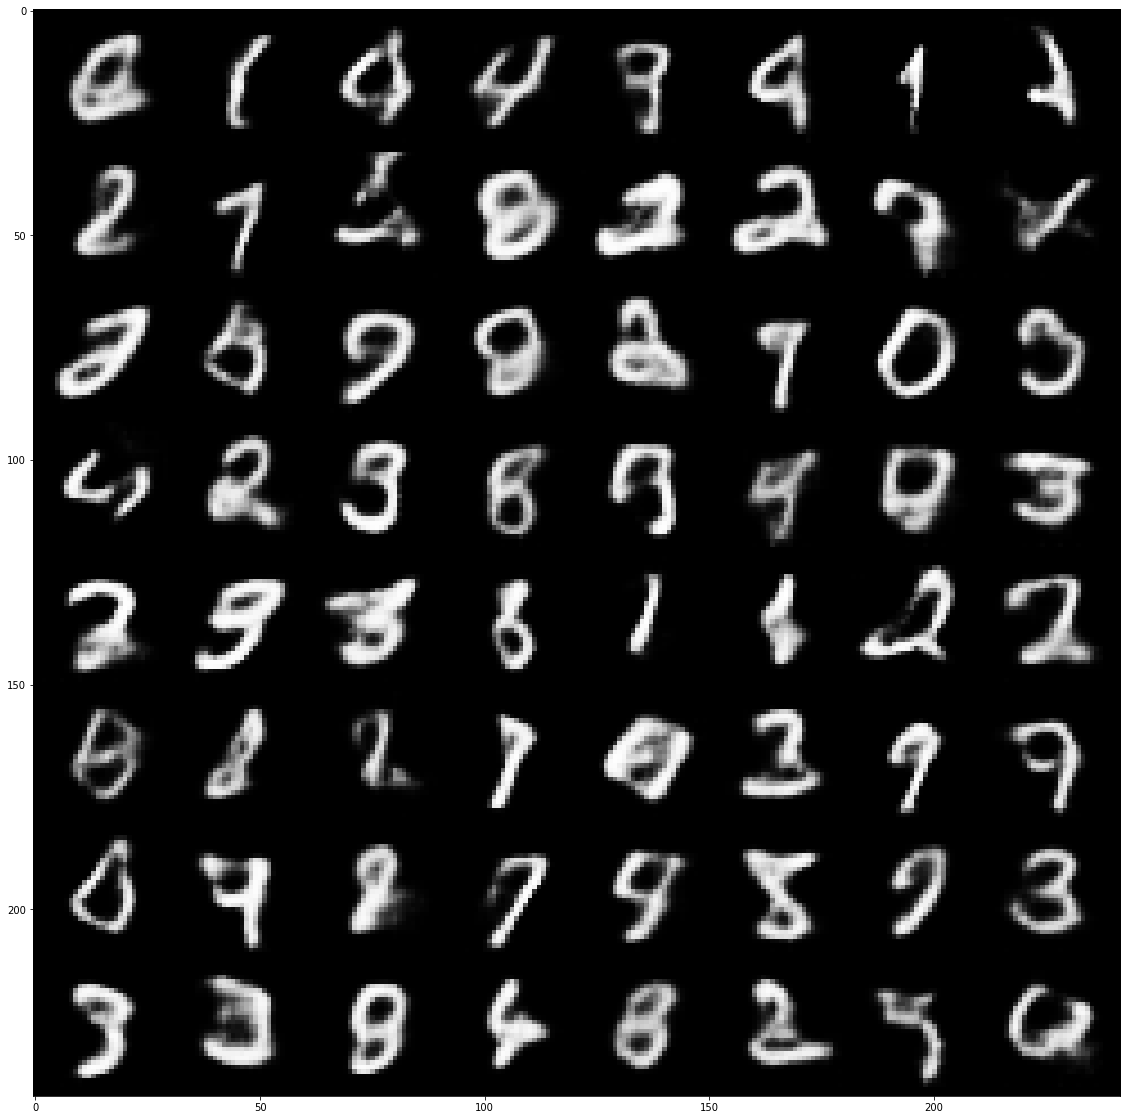

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('results/sample_8.png'))